# M4 Competition

This shows an example with just 4 series of the M4 dataset. If you want
to run it yourself on all of them, you can refer to [this
notebook](https://www.kaggle.com/code/lemuz90/m4-competition).

In [1]:
import random

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from utilsforecast.plotting import plot_series

from mlforecast import MLForecast
from mlforecast.lag_transforms import (
    ExponentiallyWeightedMean,
    RollingMean,
)
from mlforecast.lgb_cv import LightGBMCV
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals

In [ ]:
#| echo: false
import warnings

warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)

In [4]:
df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
ids = df['unique_id'].unique()
random.seed(0)
sample_ids = random.choices(ids, k=4)
sample_df = df[df['unique_id'].isin(sample_ids)]
sample_df

,unique_id,ds,y
86796,H196,1,11.8
86797,H196,2,11.4
86798,H196,3,11.1
86799,H196,4,10.8
86800,H196,5,10.6
...,...,...,...
325235,H413,1004,99.0
325236,H413,1005,88.0
325237,H413,1006,47.0
325238,H413,1007,41.0


We now split this data into train and validation.

In [5]:
horizon = 48
valid = sample_df.groupby('unique_id').tail(horizon)
train = sample_df.drop(valid.index)
train.shape, valid.shape

((3840, 3), (192, 3))

## Creating the forecaster

In [6]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(random_state=0, verbosity=-1),
    freq=1,
    lags=[24 * (i+1) for i in range(7)],
    lag_transforms={
        48: [ExponentiallyWeightedMean(alpha=0.3)],
    },
    num_threads=1,
    target_transforms=[Differences([24])],
)

In [7]:
fcst

MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'exponentially_weighted_mean_lag48_alpha0.3'], date_features=[], num_threads=1)

Once we have this setup we can compute the features and fit the model.

## Fitting and predicting

In [8]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(random_state=0, verbosity=-1),
    freq=1,
    lags=[24 * (i+1) for i in range(7)],
    lag_transforms={
        48: [ExponentiallyWeightedMean(alpha=0.3)],
    },
    num_threads=1,
    target_transforms=[Differences([24])],
)

In [14]:
train2 = train.copy()
train2['weight'] = np.random.default_rng(seed=0).random(train2.shape[0])
fcst.fit(train2, weight_col='weight', as_numpy=True).predict(5)

,unique_id,ds,LGBMRegressor
0,H196,961,16.079737
1,H196,962,15.679737
2,H196,963,15.279737
3,H196,964,14.979737
4,H196,965,14.679737
5,H256,961,13.279737
6,H256,962,12.679737
7,H256,963,12.379737
8,H256,964,12.079737
9,H256,965,11.879737


In [15]:
fcst.cross_validation(train2, n_windows=2, h=5, weight_col='weight', as_numpy=True)

,unique_id,ds,cutoff,y,LGBMRegressor
0,H196,951,950,24.4,24.288850
1,H196,952,950,24.3,24.188850
2,H196,953,950,23.8,23.688850
3,H196,954,950,22.8,22.688850
4,H196,955,950,21.2,21.088850
5,H256,951,950,19.5,19.688850
6,H256,952,950,19.4,19.488850
7,H256,953,950,18.9,19.088850
8,H256,954,950,18.3,18.388850
9,H256,955,950,17.0,17.088850


In [16]:
fcst.fit(train, fitted=True);

In [17]:
expected_future = fcst.make_future_dataframe(h=1)
expected_future

,unique_id,ds
0,H196,961
1,H256,961
2,H381,961
3,H413,961


In [18]:
missing_future = fcst.get_missing_future(h=1, X_df=expected_future.head(2))
pd.testing.assert_frame_equal(
    missing_future,
    expected_future.tail(2).reset_index(drop=True)
)

In [19]:
fcst.forecast_fitted_values()

,unique_id,ds,y,LGBMRegressor
0,H196,193,12.7,12.671271
1,H196,194,12.3,12.271271
2,H196,195,11.9,11.871271
3,H196,196,11.7,11.671271
4,H196,197,11.4,11.471271
...,...,...,...,...
3067,H413,956,59.0,68.280574
3068,H413,957,58.0,70.427570
3069,H413,958,53.0,44.767965
3070,H413,959,38.0,48.691257


In [20]:
fcst.forecast_fitted_values(level=[90])

,unique_id,ds,y,LGBMRegressor,LGBMRegressor-lo-90,LGBMRegressor-hi-90
0,H196,193,12.7,12.671271,12.540634,12.801909
1,H196,194,12.3,12.271271,12.140634,12.401909
2,H196,195,11.9,11.871271,11.740634,12.001909
3,H196,196,11.7,11.671271,11.540634,11.801909
4,H196,197,11.4,11.471271,11.340634,11.601909
...,...,...,...,...,...,...
3067,H413,956,59.0,68.280574,58.846640,77.714509
3068,H413,957,58.0,70.427570,60.993636,79.861504
3069,H413,958,53.0,44.767965,35.334031,54.201899
3070,H413,959,38.0,48.691257,39.257323,58.125191


Once we’ve run this we’re ready to compute our predictions.

In [21]:
predictions = fcst.predict(horizon)

We can see at a couple of results.

In [22]:
results = valid.merge(predictions, on=['unique_id', 'ds'])
fig = plot_series(forecasts_df=results)

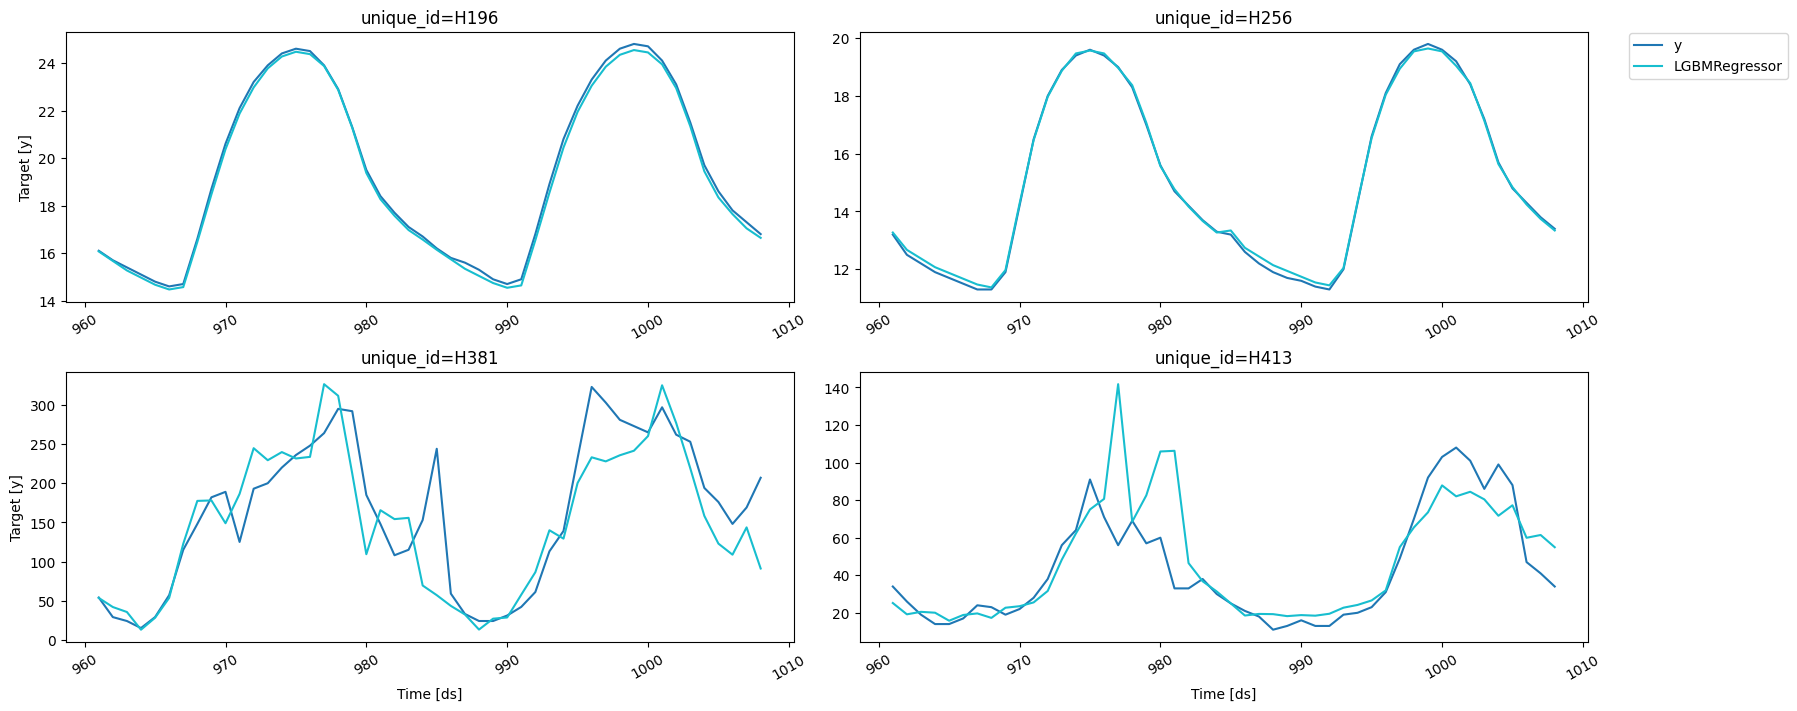

In [23]:
fig

### Prediction intervals

With [`MLForecast`](https://Nixtla.github.io/mlforecast/forecast.html#mlforecast),
you can generate prediction intervals using Conformal Prediction. To
configure Conformal Prediction, you need to pass an instance of the
[`PredictionIntervals`](https://Nixtla.github.io/mlforecast/utils.html#predictionintervals)
class to the `prediction_intervals` argument of the `fit` method. The
class takes three parameters: `n_windows`, `h` and `method`.

-   `n_windows` represents the number of cross-validation windows used
    to calibrate the intervals
-   `h` is the forecast horizon
-   `method` can be `conformal_distribution` or `conformal_error`;
    `conformal_distribution` (default) creates forecasts paths based on
    the cross-validation errors and calculate quantiles using those
    paths, on the other hand `conformal_error` calculates the error
    quantiles to produce prediction intervals. The strategy will adjust
    the intervals for each horizon step, resulting in different widths
    for each step. Please note that a minimum of 2 cross-validation
    windows must be used.

In [24]:
fcst.fit(
    train,
    prediction_intervals=PredictionIntervals(n_windows=3, h=48)
)

MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'exponentially_weighted_mean_lag48_alpha0.3'], date_features=[], num_threads=1)

After that, you just have to include your desired confidence levels to
the `predict` method using the `level` argument. Levels must lie between
0 and 100.

In [25]:
predictions_w_intervals = fcst.predict(48, level=[50, 80, 95])
predictions_w_intervals.head()

,unique_id,ds,LGBMRegressor,LGBMRegressor-lo-95,LGBMRegressor-lo-80,LGBMRegressor-lo-50,LGBMRegressor-hi-50,LGBMRegressor-hi-80,LGBMRegressor-hi-95
0,H196,961,16.071271,15.958042,15.971271,16.005091,16.137452,16.171271,16.184501
1,H196,962,15.671271,15.553632,15.553632,15.578632,15.763911,15.788911,15.788911
2,H196,963,15.271271,15.153632,15.153632,15.162452,15.380091,15.388911,15.388911
3,H196,964,14.971271,14.858042,14.871271,14.905091,15.037452,15.071271,15.084501
4,H196,965,14.671271,14.553632,14.553632,14.562452,14.780091,14.788911,14.788911


Let’s explore the generated intervals.

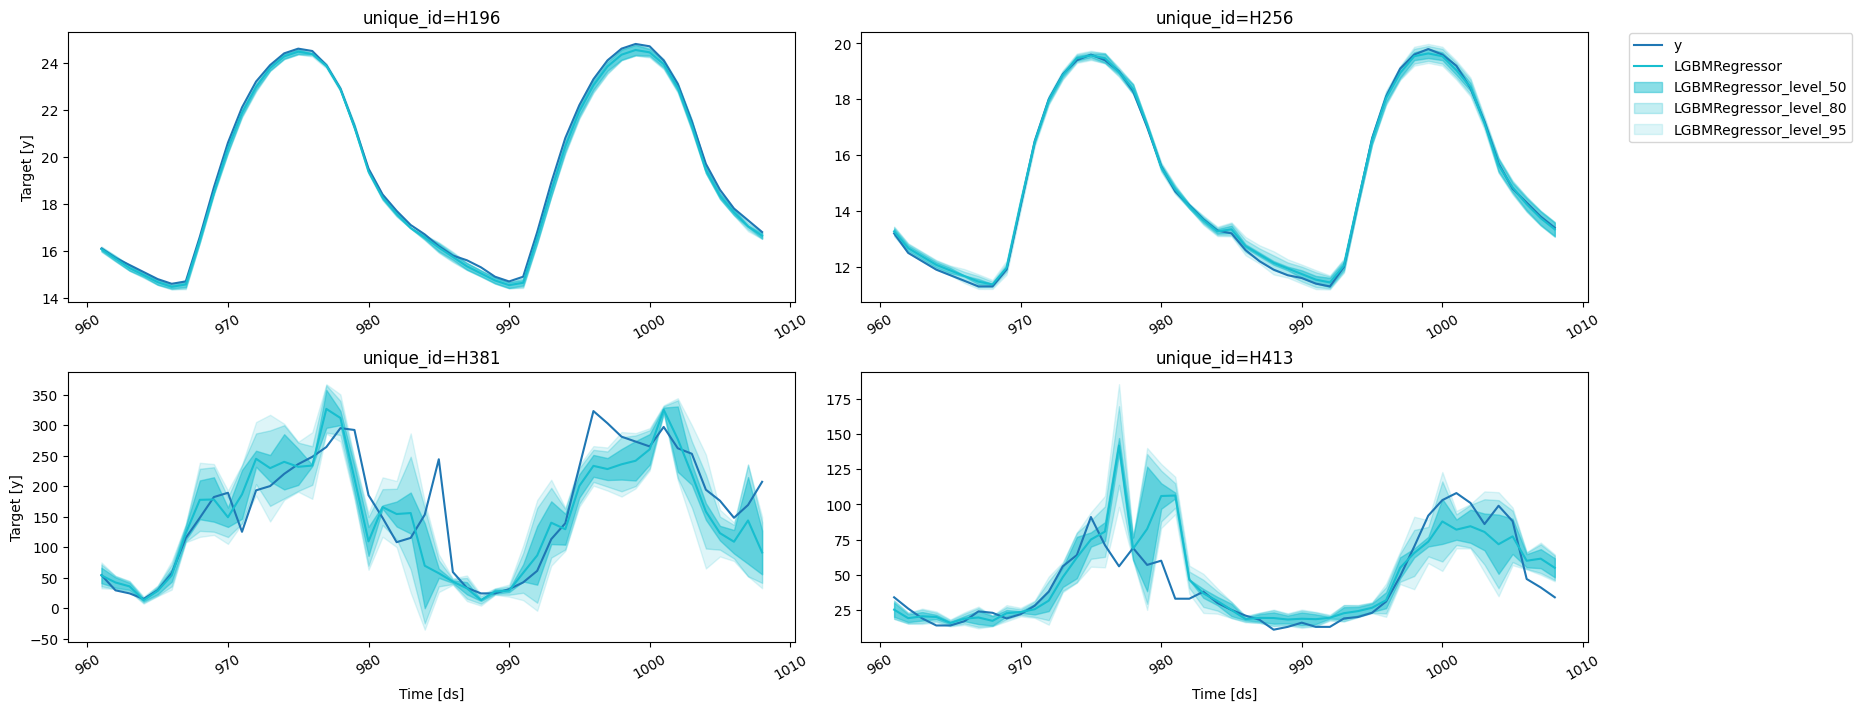

In [26]:
results = valid.merge(predictions_w_intervals, on=['unique_id', 'ds'])
fig = plot_series(forecasts_df=results, level=[50, 80, 95])
fig

If you want to reduce the computational time and produce intervals with
the same width for the whole forecast horizon, simple pass `h=1` to the
[`PredictionIntervals`](https://Nixtla.github.io/mlforecast/utils.html#predictionintervals)
class. The caveat of this strategy is that in some cases, variance of
the absolute residuals maybe be small (even zero), so the intervals may
be too narrow.

In [27]:
fcst.fit(
    train,
    prediction_intervals=PredictionIntervals(n_windows=3, h=1)
);

In [30]:
predictions_w_intervals_ws_1 = fcst.predict(48, level=[80, 90, 95])

Let’s explore the generated intervals.

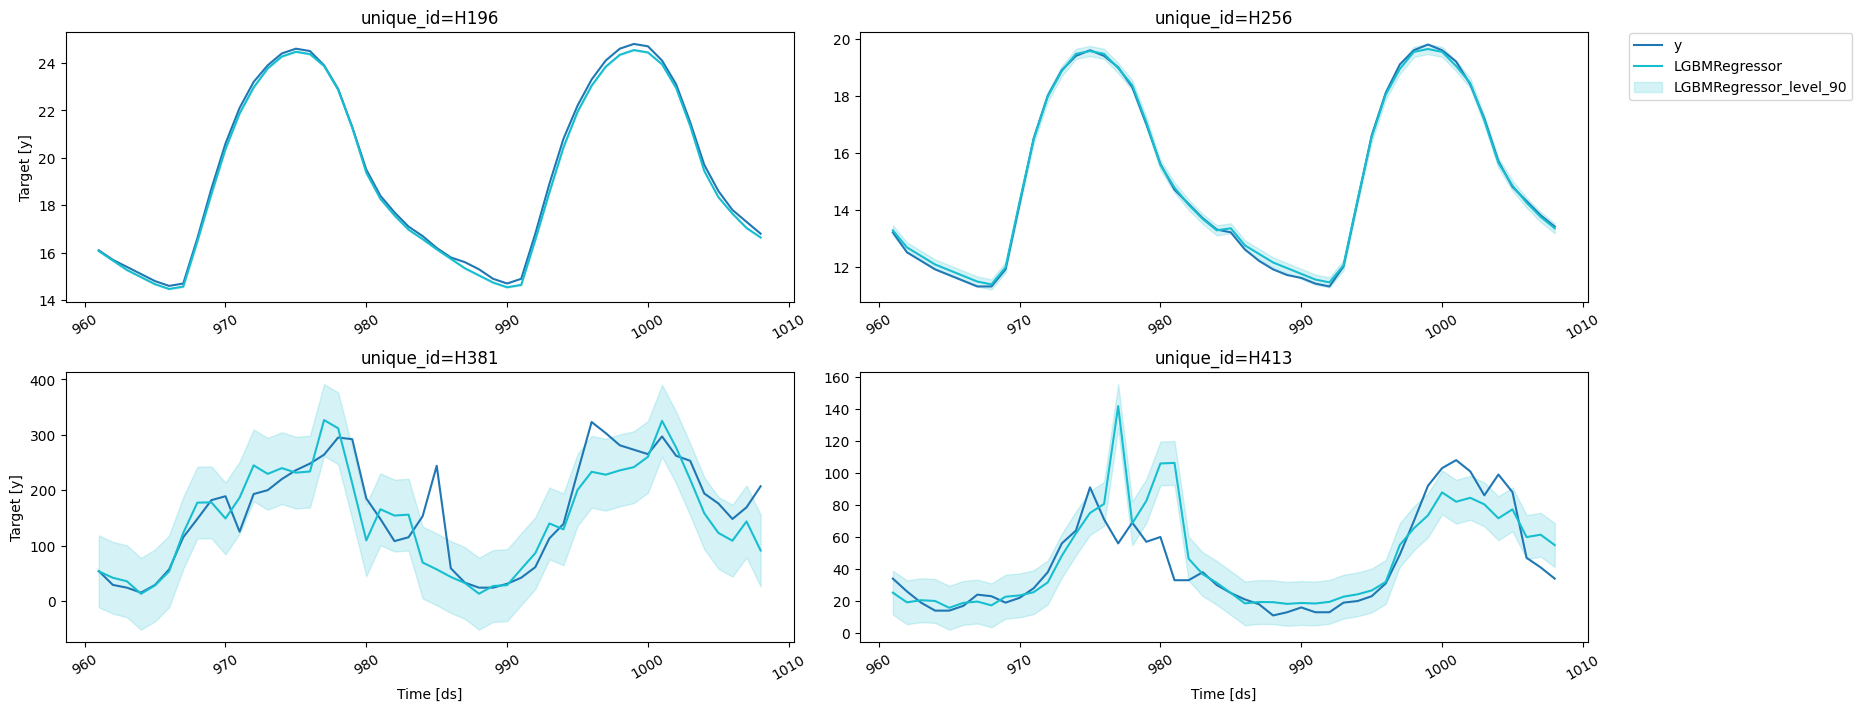

In [32]:
results = valid.merge(predictions_w_intervals_ws_1, on=['unique_id', 'ds'])
fig = plot_series(forecasts_df=results, level=[90])
fig

### Forecast using a pretrained model

MLForecast allows you to use a pretrained model to generate forecasts
for a new dataset. Simply provide a pandas dataframe containing the new
observations as the value for the `new_df` argument when calling the
`predict` method. The dataframe should have the same structure as the
one used to fit the model, including any features and time series data.
The function will then use the pretrained model to generate forecasts
for the new observations. This allows you to easily apply a pretrained
model to a new dataset and generate forecasts without the need to
retrain the model.

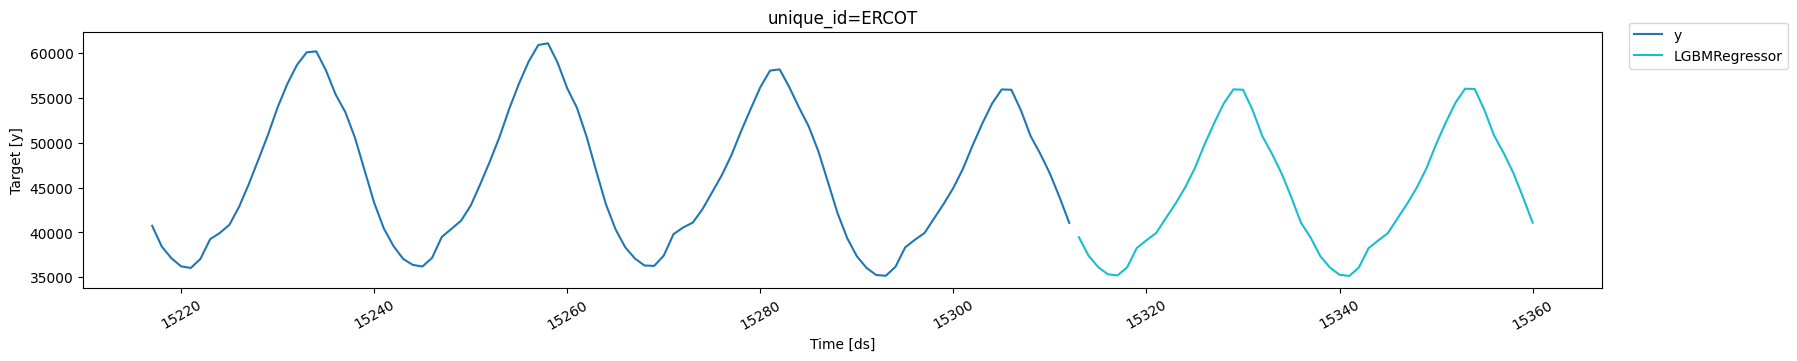

In [33]:
ercot_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/ERCOT-clean.csv')

# we have to convert the ds column to integers
# since MLForecast was trained with that structure

ercot_df['ds'] = np.arange(1, len(ercot_df) + 1)
# use the `new_df` argument to pass the ercot dataset
ercot_fcsts = fcst.predict(horizon, new_df=ercot_df)
fig = plot_series(ercot_df, ercot_fcsts, max_insample_length=48 * 2)
fig

### Preprocess

If you want to take a look at the data that will be used to train the
models you can call `Forecast.preprocess`.

In [34]:
prep_df = fcst.preprocess(train)
prep_df

,unique_id,ds,y,lag24,lag48,lag72,lag96,lag120,lag144,lag168,exponentially_weighted_mean_lag48_alpha0.3
86988,H196,193,0.1,0.0,0.0,0.0,0.3,0.1,0.1,0.3,0.002810
86989,H196,194,0.1,-0.1,0.1,0.0,0.3,0.1,0.1,0.3,0.031967
86990,H196,195,0.1,-0.1,0.1,0.0,0.3,0.1,0.2,0.1,0.052377
86991,H196,196,0.1,0.0,0.0,0.0,0.3,0.2,0.1,0.2,0.036664
86992,H196,197,0.0,0.0,0.0,0.1,0.2,0.2,0.1,0.2,0.025665
...,...,...,...,...,...,...,...,...,...,...,...
325187,H413,956,0.0,10.0,1.0,6.0,-53.0,44.0,-21.0,21.0,7.963225
325188,H413,957,9.0,10.0,10.0,-7.0,-46.0,27.0,-19.0,24.0,8.574257
325189,H413,958,16.0,8.0,5.0,-9.0,-36.0,32.0,-13.0,8.0,7.501980
325190,H413,959,-3.0,17.0,-7.0,2.0,-31.0,22.0,5.0,-2.0,3.151386


If we do this we then have to call `Forecast.fit_models`, since this only stores the series information.

In [36]:
X, y = prep_df.drop(columns=['unique_id', 'ds', 'y']), prep_df['y']
fcst.fit_models(X, y)

MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'exponentially_weighted_mean_lag48_alpha0.3'], date_features=[], num_threads=1)

In [37]:
fcst

MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'exponentially_weighted_mean_lag48_alpha0.3'], date_features=[], num_threads=1)

In [38]:
predictions2 = fcst.predict(horizon)
pd.testing.assert_frame_equal(predictions, predictions2)

If we would like to know how good our forecast will be for a specific
model and set of features then we can perform cross validation. What
cross validation does is take our data and split it in two parts, where
the first part is used for training and the second one for validation.
Since the data is time dependant we usually take the last *x*
observations from our data as the validation set.

This process is implemented in
[`MLForecast.cross_validation`](https://Nixtla.github.io/mlforecast/forecast.html#mlforecast.cross_validation),
which takes our data and performs the process described above for
`n_windows` times where each window has `h` validation samples in it.
For example, if we have 100 samples and we want to perform 2 backtests
each of size 14, the splits will be as follows:

1. Train: 1 to 72. Validation: 73 to 86.
2. Train: 1 to 86. Validation: 87 to 100.

You can control the size between each cross validation window using the
`step_size` argument. For example, if we have 100 samples and we want to
perform 2 backtests each of size 14 and move one step ahead in each fold
(`step_size=1`), the splits will be as follows:

1. Train: 1 to 85. Validation: 86 to 99.
2. Train: 1 to 86. Validation: 87 to 100.

You can also perform cross validation without refitting your models for
each window by setting `refit=False`. This allows you to evaluate the
performance of your models using multiple window sizes without having to
retrain them each time.

In [39]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(random_state=0, verbosity=-1),
    freq=1,
    lags=[24 * (i+1) for i in range(7)],
    lag_transforms={
        1: [RollingMean(window_size=24)],
        24: [RollingMean(window_size=24)],
        48: [ExponentiallyWeightedMean(alpha=0.3)],
    },
    num_threads=1,
    target_transforms=[Differences([24])],
)
cv_results = fcst.cross_validation(
    train,
    n_windows=2,
    h=horizon,
    step_size=horizon,
    fitted=True,
)
cv_results

,unique_id,ds,cutoff,y,LGBMRegressor
0,H196,865,864,15.5,15.373393
1,H196,866,864,15.1,14.973393
2,H196,867,864,14.8,14.673393
3,H196,868,864,14.4,14.373393
4,H196,869,864,14.2,14.073393
...,...,...,...,...,...
379,H413,956,912,59.0,64.284167
380,H413,957,912,58.0,64.830429
381,H413,958,912,53.0,40.726851
382,H413,959,912,38.0,42.739657


Since we set `fitted=True` we can access the predictions for the
training sets as well with the `cross_validation_fitted_values` method.

In [40]:
fcst.cross_validation_fitted_values()

,unique_id,ds,fold,y,LGBMRegressor
0,H196,193,0,12.7,12.673393
1,H196,194,0,12.3,12.273393
2,H196,195,0,11.9,11.873393
3,H196,196,0,11.7,11.673393
4,H196,197,0,11.4,11.473393
...,...,...,...,...,...
5563,H413,908,1,49.0,50.620196
5564,H413,909,1,39.0,35.972331
5565,H413,910,1,29.0,29.359678
5566,H413,911,1,24.0,25.784563


We can also compute prediction intervals by passing a configuration to
`prediction_intervals` as well as values for the width through `levels`.

In [41]:
cv_results_intervals = fcst.cross_validation(
    train,
    n_windows=2,
    h=horizon,
    step_size=horizon,
    prediction_intervals=PredictionIntervals(h=horizon),
    level=[80, 90]
)
cv_results_intervals

,unique_id,ds,cutoff,y,LGBMRegressor,LGBMRegressor-lo-90,LGBMRegressor-lo-80,LGBMRegressor-hi-80,LGBMRegressor-hi-90
0,H196,865,864,15.5,15.373393,15.311379,15.316528,15.430258,15.435407
1,H196,866,864,15.1,14.973393,14.940556,14.940556,15.006230,15.006230
2,H196,867,864,14.8,14.673393,14.606230,14.606230,14.740556,14.740556
3,H196,868,864,14.4,14.373393,14.306230,14.306230,14.440556,14.440556
4,H196,869,864,14.2,14.073393,14.006230,14.006230,14.140556,14.140556
...,...,...,...,...,...,...,...,...,...
379,H413,956,912,59.0,64.284167,29.890099,34.371545,94.196788,98.678234
380,H413,957,912,58.0,64.830429,56.874572,57.827689,71.833169,72.786285
381,H413,958,912,53.0,40.726851,35.296195,35.846206,45.607495,46.157506
382,H413,959,912,38.0,42.739657,35.292153,35.807640,49.671674,50.187161


The `refit` argument allows us to control if we want to retrain the
models in every window. It can either be:

- A boolean: True will retrain on every window and False only on the first one.
- A positive integer: The models will be trained on the first window and then every `refit` windows.

In [42]:
fcst = MLForecast(
    models=LinearRegression(),
    freq=1,
    lags=[1, 24],
)
for refit, expected_models in zip([True, False, 2], [4, 1, 2]):
    fcst.cross_validation(
        train,
        n_windows=4,
        h=horizon,
        refit=refit,
    )
assert len(fcst.cv_models_) == expected_models

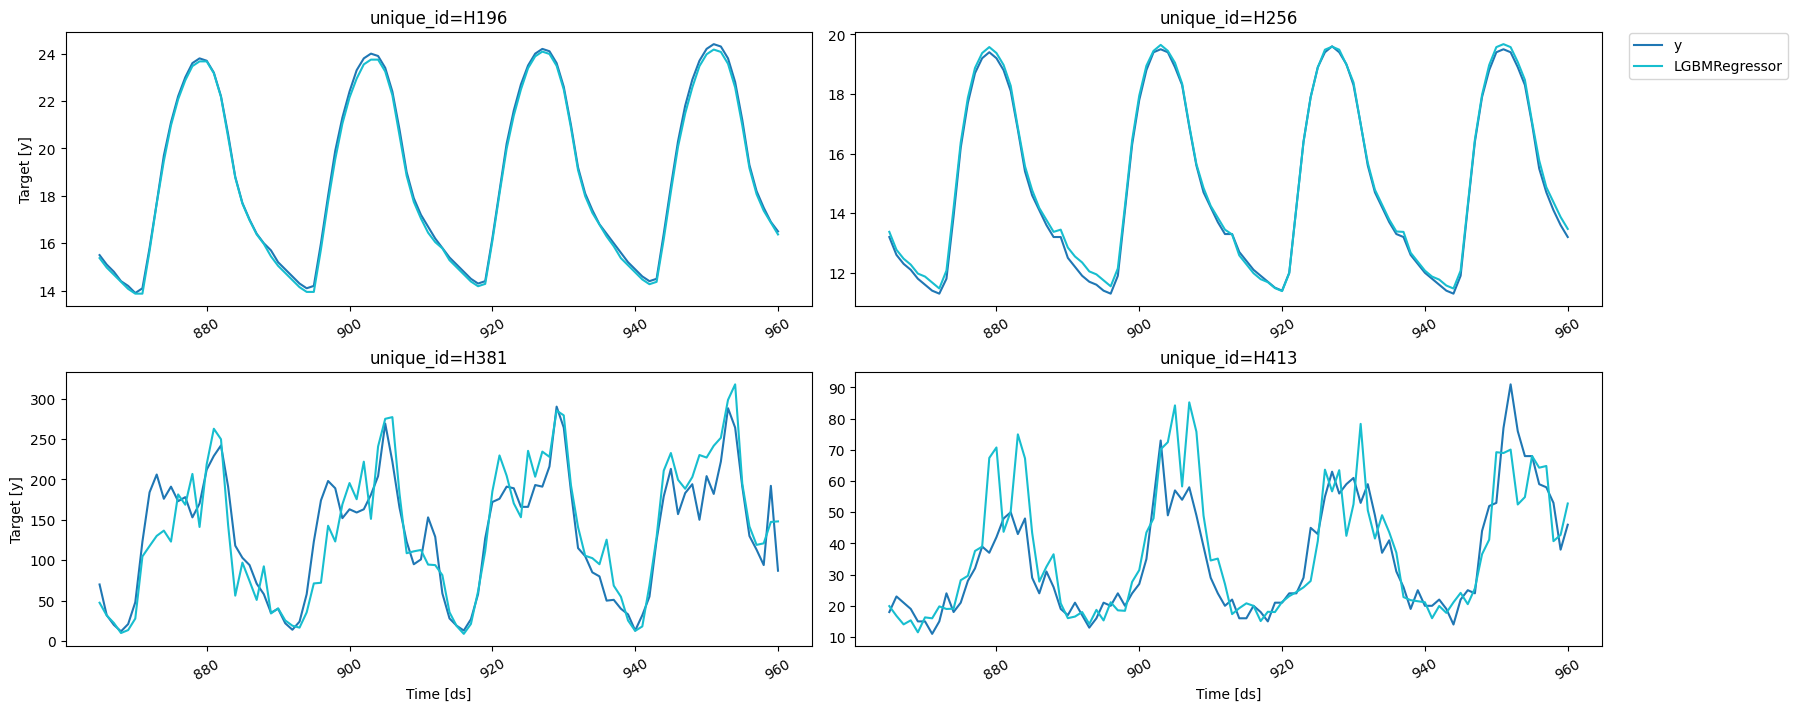

In [43]:
fig = plot_series(forecasts_df=cv_results.drop(columns='cutoff'))
fig

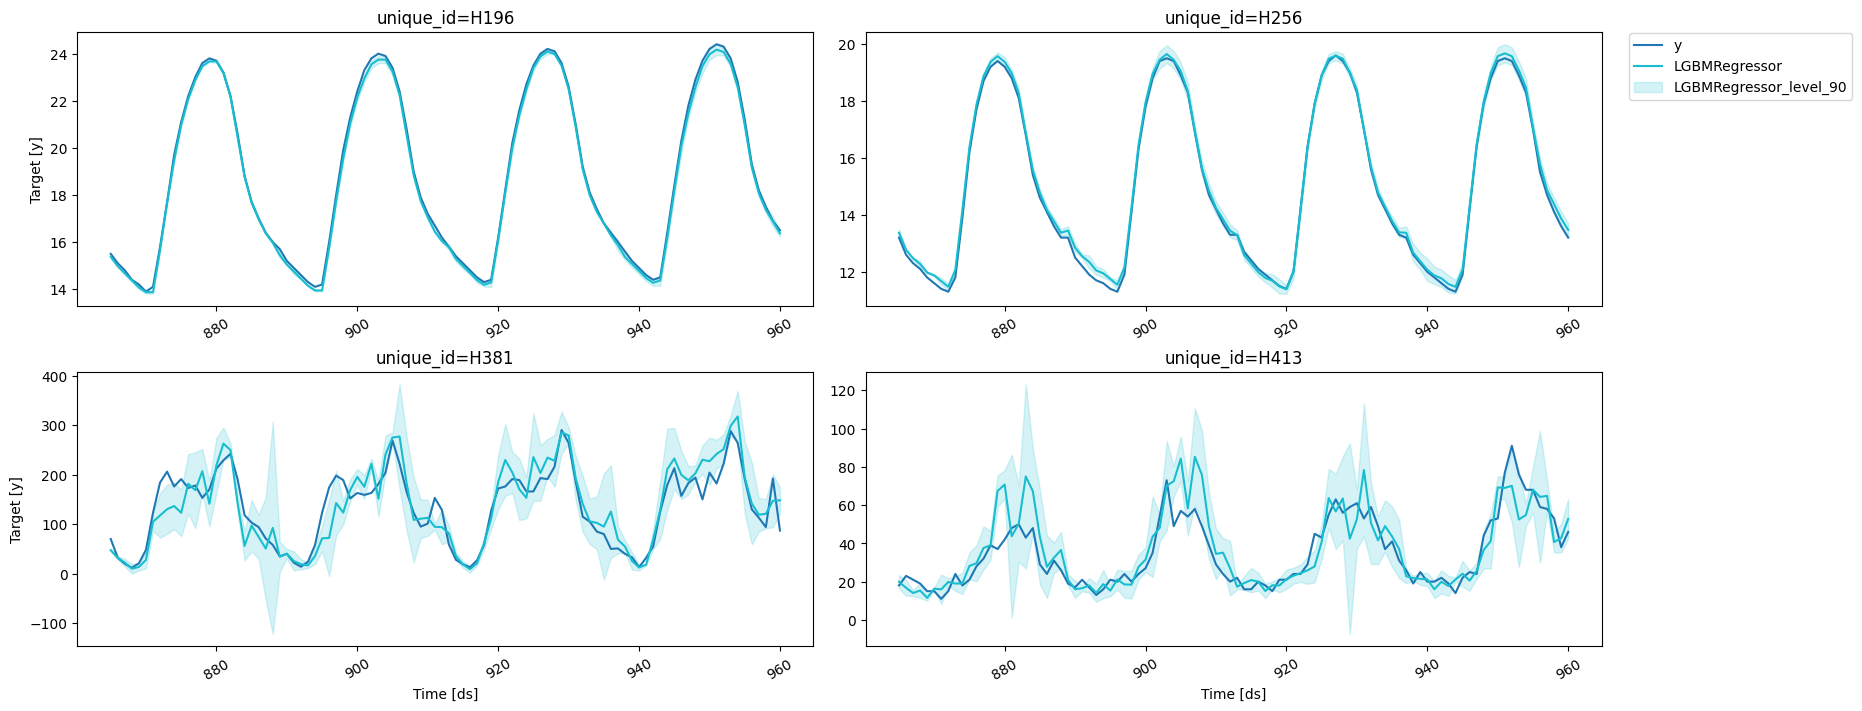

In [44]:
fig = plot_series(forecasts_df=cv_results_intervals.drop(columns='cutoff'), level=[90])
fig

### Using LightGBMCV to tune your forecasts

Once you’ve found a set of features and parameters that work for your
problem you can build a forecast object from it using
[`MLForecast.from_cv`](https://Nixtla.github.io/mlforecast/forecast.html#mlforecast.from_cv),
which takes the trained
[`LightGBMCV`](https://Nixtla.github.io/mlforecast/lgb_cv.html#lightgbmcv)
object and builds an
[`MLForecast`](https://Nixtla.github.io/mlforecast/forecast.html#mlforecast)
object that will use the same features and parameters. Then you can call
fit and predict as you normally would.

In [45]:
cv = LightGBMCV(
    freq=1,
    lags=[24 * (i+1) for i in range(7)],
    lag_transforms={
        48: [ExponentiallyWeightedMean(alpha=0.3)],
    },
    num_threads=1,
    target_transforms=[Differences([24])]
)
hist = cv.fit(
    train,
    n_windows=2,
    h=horizon,
    params={'verbosity': -1},
)

[10] mape: 0.118569
[20] mape: 0.111506
[30] mape: 0.107314
[40] mape: 0.106089
[50] mape: 0.106630
Early stopping at round 50
Using best iteration: 40


In [46]:
fcst = MLForecast.from_cv(cv)
assert cv.best_iteration_ == fcst.models['LGBMRegressor'].n_estimators